In [29]:
from IPython.display import HTML

url = "https://mnist-gan-byluvgoel.netlify.app"

HTML(f"""
<style>@keyframes g{{0%,100%{{background-position:0 50%}}50%{{background-position:100% 50%}}}}</style>
<div style="text-align:center;padding:20px;background:linear-gradient(135deg,#667eea,#764ba2,#667eea);background-size:200%;animation:g 4s ease infinite;border-radius:10px">
<h2 style="color:#fff;margin:0 0 5px">MNIST GAN Demo by Luv Goel</h2><br>
<a href="{url}" target="_blank" style="display:inline-block;padding:15px 40px;background:#fff;color:#667eea;font-weight:bold;font-size:16px;border-radius:10px;box-shadow:0 5px 15px rgba(0,0,0,.3);text-decoration:none;transition:transform .3s" onmouseover="this.style.transform='scale(1.05)'" onmouseout="this.style.transform='scale(1)'">Click Here to Open Website</a>
</div>
""")

In [1]:
"""
MNIST GAN Implementation
A clean, educational implementation of a Generative Adversarial Network
for generating handwritten digits similar to MNIST.

Key Concepts:
- Generator: Creates fake images from random noise
- Discriminator: Distinguishes real from fake images
- Adversarial Training: Both networks compete and improve
"""

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}\n")

# Hyperparameters
LATENT_DIM = 100       # Size of random noise vector
IMAGE_SIZE = 28 * 28   # MNIST images are 28x28 = 784 pixels
HIDDEN_DIM = 256       # Hidden layer size
BATCH_SIZE = 128
NUM_EPOCHS = 50
LEARNING_RATE = 0.0002

Using device: cpu



In [3]:
# 1. LOAD MNIST DATASET

print("Loading MNIST dataset...")

# Transform: convert to tensor and normalize to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Download and load MNIST
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

print(f"✓ Loaded {len(train_dataset)} training images\n")

Loading MNIST dataset...


100%|██████████| 9.91M/9.91M [00:00<00:00, 36.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.10MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.90MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]

✓ Loaded 60000 training images



In [4]:
# 2. DEFINE GENERATOR NETWORK

class Generator(nn.Module):
    """
    Generator Network: Transforms random noise into fake images

    Input:  Random noise vector (100 dimensions)
    Output: Fake image (784 pixels = 28x28)
    """

    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            # Layer 1: 100 -> 256
            nn.Linear(LATENT_DIM, HIDDEN_DIM),
            nn.LeakyReLU(0.2),

            # Layer 2: 256 -> 512
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM * 2),
            nn.LeakyReLU(0.2),

            # Layer 3: 512 -> 1024
            nn.Linear(HIDDEN_DIM * 2, HIDDEN_DIM * 4),
            nn.LeakyReLU(0.2),

            # Output: 1024 -> 784
            nn.Linear(HIDDEN_DIM * 4, IMAGE_SIZE),
            nn.Tanh()  # Output range [-1, 1]
        )

    def forward(self, z):
        """Generate fake image from noise"""
        return self.model(z)

In [5]:
# 3. DEFINE DISCRIMINATOR NETWORK

class Discriminator(nn.Module):
    """
    Discriminator Network: Judges whether images are real or fake

    Input:  Image (784 pixels)
    Output: Probability that image is real (0 to 1)
    """

    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            # Layer 1: 784 -> 512
            nn.Linear(IMAGE_SIZE, HIDDEN_DIM * 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            # Layer 2: 512 -> 256
            nn.Linear(HIDDEN_DIM * 2, HIDDEN_DIM),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            # Output: 256 -> 1
            nn.Linear(HIDDEN_DIM, 1),
            nn.Sigmoid()  # Output probability [0, 1]
        )

    def forward(self, img):
        """Judge if image is real or fake"""
        return self.model(img)

In [6]:
# 4. INITIALIZE NETWORKS AND OPTIMIZERS

# Create networks
generator = Generator().to(device)
discriminator = Discriminator().to(device)

print("=" * 70)
print("GENERATOR ARCHITECTURE")
print("=" * 70)
print(generator)
print(f"\nParameters: {sum(p.numel() for p in generator.parameters()):,}\n")

print("=" * 70)
print("DISCRIMINATOR ARCHITECTURE")
print("=" * 70)
print(discriminator)
print(f"\nParameters: {sum(p.numel() for p in discriminator.parameters()):,}\n")

# Loss function (Binary Cross Entropy)
criterion = nn.BCELoss()

# Optimizers (Adam works well for GANs)
optimizer_G = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

GENERATOR ARCHITECTURE
Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)

Parameters: 1,486,352

DISCRIMINATOR ARCHITECTURE
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

Parameters: 533,505



In [7]:
# 5. HELPER FUNCTIONS

def generate_noise(batch_size):
    """Generate random noise for the generator"""
    return torch.randn(batch_size, LATENT_DIM).to(device)

def save_generated_images(epoch, num_images=16):
    """Save a grid of generated images"""
    generator.eval()
    with torch.no_grad():
        # Generate images
        noise = generate_noise(num_images)
        fake_images = generator(noise).view(-1, 1, 28, 28)

        # Denormalize from [-1, 1] to [0, 1]
        fake_images = (fake_images + 1) / 2

        # Create and save grid
        grid = torchvision.utils.make_grid(fake_images, nrow=4, padding=2)
        plt.figure(figsize=(8, 8))
        plt.imshow(grid.cpu().permute(1, 2, 0).squeeze(), cmap='gray')
        plt.axis('off')
        plt.title(f'Generated Images - Epoch {epoch}', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'gan_epoch_{epoch:03d}.png', dpi=150, bbox_inches='tight')
        plt.close()

    generator.train()

In [8]:
# 6. TRAINING LOOP

print("STARTING GAN TRAINING")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LEARNING_RATE}\n")

# Track losses
G_losses = []
D_losses = []

for epoch in range(NUM_EPOCHS):
    epoch_g_loss = 0
    epoch_d_loss = 0

    pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS}')

    for real_images, _ in pbar:
        batch_size = real_images.size(0)
        real_images = real_images.view(batch_size, -1).to(device)  # Flatten

        # Create labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ====================================================================
        # TRAIN DISCRIMINATOR
        # Goal: Maximize log(D(x)) + log(1 - D(G(z)))
        # ====================================================================

        optimizer_D.zero_grad()

        # Real images
        real_output = discriminator(real_images)
        d_loss_real = criterion(real_output, real_labels)

        # Fake images
        noise = generate_noise(batch_size)
        fake_images = generator(noise)
        fake_output = discriminator(fake_images.detach())  # Don't train G here
        d_loss_fake = criterion(fake_output, fake_labels)

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # ====================================================================
        # TRAIN GENERATOR
        # Goal: Maximize log(D(G(z))) = Minimize log(1 - D(G(z)))
        # ====================================================================

        optimizer_G.zero_grad()

        # Generate fake images
        noise = generate_noise(batch_size)
        fake_images = generator(noise)
        fake_output = discriminator(fake_images)

        # Generator wants discriminator to think images are real
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()
        optimizer_G.step()

        # ====================================================================
        # STATISTICS
        # ====================================================================

        epoch_g_loss += g_loss.item()
        epoch_d_loss += d_loss.item()

        pbar.set_postfix({
            'D_loss': f'{d_loss.item():.3f}',
            'G_loss': f'{g_loss.item():.3f}',
            'D(x)': f'{real_output.mean().item():.2f}',
            'D(G(z))': f'{fake_output.mean().item():.2f}'
        })

    # Average losses
    avg_g_loss = epoch_g_loss / len(dataloader)
    avg_d_loss = epoch_d_loss / len(dataloader)

    G_losses.append(avg_g_loss)
    D_losses.append(avg_d_loss)

    # Print epoch summary
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]")
    print(f"  Generator Loss:     {avg_g_loss:.4f}")
    print(f"  Discriminator Loss: {avg_d_loss:.4f}\n")

    # Save generated images every 10 epochs
    if (epoch + 1) % 10 == 0 or epoch == 0:
        save_generated_images(epoch + 1)
        print(f"  ✓ Saved generated images\n")

print("TRAINING COMPLETED!..")

STARTING GAN TRAINING
Epochs: 50
Batch Size: 128
Learning Rate: 0.0002



Epoch 1/50: 100%|██████████| 468/468 [00:55<00:00,  8.46it/s, D_loss=0.818, G_loss=1.524, D(x)=0.81, D(G(z))=0.23]



Epoch [1/50]
  Generator Loss:     0.9959
  Discriminator Loss: 1.1484

  ✓ Saved generated images



Epoch 2/50: 100%|██████████| 468/468 [00:52<00:00,  8.96it/s, D_loss=0.740, G_loss=1.830, D(x)=0.72, D(G(z))=0.19]



Epoch [2/50]
  Generator Loss:     1.7722
  Discriminator Loss: 0.9223



Epoch 3/50: 100%|██████████| 468/468 [00:51<00:00,  9.06it/s, D_loss=0.798, G_loss=1.410, D(x)=0.61, D(G(z))=0.30]



Epoch [3/50]
  Generator Loss:     1.9335
  Discriminator Loss: 0.8589



Epoch 4/50: 100%|██████████| 468/468 [00:52<00:00,  8.97it/s, D_loss=0.822, G_loss=1.842, D(x)=0.76, D(G(z))=0.19]



Epoch [4/50]
  Generator Loss:     2.0416
  Discriminator Loss: 0.8396



Epoch 5/50: 100%|██████████| 468/468 [00:52<00:00,  8.94it/s, D_loss=0.713, G_loss=1.940, D(x)=0.70, D(G(z))=0.19]



Epoch [5/50]
  Generator Loss:     2.1189
  Discriminator Loss: 0.7751



Epoch 6/50: 100%|██████████| 468/468 [00:52<00:00,  8.85it/s, D_loss=0.880, G_loss=1.520, D(x)=0.64, D(G(z))=0.29]



Epoch [6/50]
  Generator Loss:     2.0417
  Discriminator Loss: 0.7897



Epoch 7/50: 100%|██████████| 468/468 [00:53<00:00,  8.78it/s, D_loss=0.820, G_loss=1.957, D(x)=0.75, D(G(z))=0.19]



Epoch [7/50]
  Generator Loss:     2.0353
  Discriminator Loss: 0.8013



Epoch 8/50: 100%|██████████| 468/468 [00:52<00:00,  8.88it/s, D_loss=0.966, G_loss=1.554, D(x)=0.66, D(G(z))=0.27]



Epoch [8/50]
  Generator Loss:     1.8555
  Discriminator Loss: 0.8271



Epoch 9/50: 100%|██████████| 468/468 [00:53<00:00,  8.73it/s, D_loss=0.982, G_loss=1.545, D(x)=0.70, D(G(z))=0.26]



Epoch [9/50]
  Generator Loss:     1.5875
  Discriminator Loss: 0.9224



Epoch 10/50: 100%|██████████| 468/468 [00:51<00:00,  9.02it/s, D_loss=0.937, G_loss=1.320, D(x)=0.68, D(G(z))=0.32]



Epoch [10/50]
  Generator Loss:     1.4828
  Discriminator Loss: 0.9652

  ✓ Saved generated images



Epoch 11/50: 100%|██████████| 468/468 [00:52<00:00,  8.93it/s, D_loss=1.072, G_loss=1.339, D(x)=0.69, D(G(z))=0.31]



Epoch [11/50]
  Generator Loss:     1.3506
  Discriminator Loss: 1.0222



Epoch 12/50: 100%|██████████| 468/468 [00:58<00:00,  8.05it/s, D_loss=1.072, G_loss=1.008, D(x)=0.62, D(G(z))=0.42]



Epoch [12/50]
  Generator Loss:     1.2179
  Discriminator Loss: 1.0710



Epoch 13/50: 100%|██████████| 468/468 [00:53<00:00,  8.71it/s, D_loss=1.197, G_loss=1.297, D(x)=0.70, D(G(z))=0.31]



Epoch [13/50]
  Generator Loss:     1.1744
  Discriminator Loss: 1.1004



Epoch 14/50: 100%|██████████| 468/468 [00:53<00:00,  8.80it/s, D_loss=1.135, G_loss=1.452, D(x)=0.75, D(G(z))=0.27]



Epoch [14/50]
  Generator Loss:     1.1358
  Discriminator Loss: 1.1211



Epoch 15/50: 100%|██████████| 468/468 [00:53<00:00,  8.76it/s, D_loss=1.056, G_loss=1.028, D(x)=0.62, D(G(z))=0.39]



Epoch [15/50]
  Generator Loss:     1.1381
  Discriminator Loss: 1.1211



Epoch 16/50: 100%|██████████| 468/468 [00:53<00:00,  8.71it/s, D_loss=1.258, G_loss=1.246, D(x)=0.62, D(G(z))=0.32]



Epoch [16/50]
  Generator Loss:     1.1055
  Discriminator Loss: 1.1386



Epoch 17/50: 100%|██████████| 468/468 [00:53<00:00,  8.70it/s, D_loss=1.222, G_loss=1.033, D(x)=0.54, D(G(z))=0.38]



Epoch [17/50]
  Generator Loss:     1.0774
  Discriminator Loss: 1.1516



Epoch 18/50: 100%|██████████| 468/468 [00:54<00:00,  8.53it/s, D_loss=1.129, G_loss=1.261, D(x)=0.66, D(G(z))=0.32]



Epoch [18/50]
  Generator Loss:     1.0705
  Discriminator Loss: 1.1593



Epoch 19/50: 100%|██████████| 468/468 [00:56<00:00,  8.26it/s, D_loss=1.194, G_loss=1.047, D(x)=0.56, D(G(z))=0.39]



Epoch [19/50]
  Generator Loss:     1.0782
  Discriminator Loss: 1.1577



Epoch 20/50: 100%|██████████| 468/468 [00:55<00:00,  8.47it/s, D_loss=1.283, G_loss=1.149, D(x)=0.59, D(G(z))=0.35]



Epoch [20/50]
  Generator Loss:     1.0510
  Discriminator Loss: 1.1773

  ✓ Saved generated images



Epoch 21/50: 100%|██████████| 468/468 [00:55<00:00,  8.48it/s, D_loss=1.172, G_loss=1.073, D(x)=0.57, D(G(z))=0.38]



Epoch [21/50]
  Generator Loss:     1.0531
  Discriminator Loss: 1.1744



Epoch 22/50: 100%|██████████| 468/468 [00:54<00:00,  8.53it/s, D_loss=1.162, G_loss=1.061, D(x)=0.60, D(G(z))=0.38]



Epoch [22/50]
  Generator Loss:     1.0322
  Discriminator Loss: 1.1905



Epoch 23/50: 100%|██████████| 468/468 [00:54<00:00,  8.59it/s, D_loss=1.172, G_loss=1.064, D(x)=0.66, D(G(z))=0.37]



Epoch [23/50]
  Generator Loss:     1.0326
  Discriminator Loss: 1.1838



Epoch 24/50: 100%|██████████| 468/468 [00:54<00:00,  8.55it/s, D_loss=1.208, G_loss=1.047, D(x)=0.66, D(G(z))=0.38]



Epoch [24/50]
  Generator Loss:     1.0341
  Discriminator Loss: 1.1892



Epoch 25/50: 100%|██████████| 468/468 [00:54<00:00,  8.57it/s, D_loss=1.167, G_loss=1.095, D(x)=0.63, D(G(z))=0.37]



Epoch [25/50]
  Generator Loss:     1.0201
  Discriminator Loss: 1.1943



Epoch 26/50: 100%|██████████| 468/468 [00:53<00:00,  8.74it/s, D_loss=1.287, G_loss=1.151, D(x)=0.62, D(G(z))=0.34]



Epoch [26/50]
  Generator Loss:     1.0149
  Discriminator Loss: 1.2020



Epoch 27/50: 100%|██████████| 468/468 [00:54<00:00,  8.64it/s, D_loss=1.154, G_loss=1.168, D(x)=0.61, D(G(z))=0.34]



Epoch [27/50]
  Generator Loss:     1.0110
  Discriminator Loss: 1.2010



Epoch 28/50: 100%|██████████| 468/468 [00:54<00:00,  8.57it/s, D_loss=1.245, G_loss=0.904, D(x)=0.54, D(G(z))=0.43]



Epoch [28/50]
  Generator Loss:     1.0018
  Discriminator Loss: 1.2122



Epoch 29/50: 100%|██████████| 468/468 [00:53<00:00,  8.70it/s, D_loss=1.202, G_loss=0.848, D(x)=0.52, D(G(z))=0.46]



Epoch [29/50]
  Generator Loss:     0.9971
  Discriminator Loss: 1.2112



Epoch 30/50: 100%|██████████| 468/468 [00:53<00:00,  8.71it/s, D_loss=1.290, G_loss=0.962, D(x)=0.54, D(G(z))=0.41]



Epoch [30/50]
  Generator Loss:     0.9843
  Discriminator Loss: 1.2282

  ✓ Saved generated images



Epoch 31/50: 100%|██████████| 468/468 [00:54<00:00,  8.61it/s, D_loss=1.176, G_loss=1.219, D(x)=0.62, D(G(z))=0.33]



Epoch [31/50]
  Generator Loss:     0.9748
  Discriminator Loss: 1.2245



Epoch 32/50: 100%|██████████| 468/468 [00:53<00:00,  8.76it/s, D_loss=1.235, G_loss=1.046, D(x)=0.62, D(G(z))=0.39]



Epoch [32/50]
  Generator Loss:     0.9749
  Discriminator Loss: 1.2281



Epoch 33/50: 100%|██████████| 468/468 [00:54<00:00,  8.66it/s, D_loss=1.237, G_loss=1.078, D(x)=0.63, D(G(z))=0.37]



Epoch [33/50]
  Generator Loss:     0.9728
  Discriminator Loss: 1.2309



Epoch 34/50: 100%|██████████| 468/468 [00:55<00:00,  8.47it/s, D_loss=1.248, G_loss=0.974, D(x)=0.51, D(G(z))=0.41]



Epoch [34/50]
  Generator Loss:     0.9601
  Discriminator Loss: 1.2356



Epoch 35/50: 100%|██████████| 468/468 [00:54<00:00,  8.57it/s, D_loss=1.223, G_loss=1.027, D(x)=0.61, D(G(z))=0.38]



Epoch [35/50]
  Generator Loss:     0.9584
  Discriminator Loss: 1.2437



Epoch 36/50: 100%|██████████| 468/468 [00:54<00:00,  8.60it/s, D_loss=1.241, G_loss=1.017, D(x)=0.62, D(G(z))=0.39]



Epoch [36/50]
  Generator Loss:     0.9498
  Discriminator Loss: 1.2406



Epoch 37/50: 100%|██████████| 468/468 [00:55<00:00,  8.48it/s, D_loss=1.215, G_loss=1.085, D(x)=0.62, D(G(z))=0.37]



Epoch [37/50]
  Generator Loss:     0.9547
  Discriminator Loss: 1.2425



Epoch 38/50: 100%|██████████| 468/468 [00:54<00:00,  8.61it/s, D_loss=1.260, G_loss=0.888, D(x)=0.59, D(G(z))=0.44]



Epoch [38/50]
  Generator Loss:     0.9483
  Discriminator Loss: 1.2418



Epoch 39/50: 100%|██████████| 468/468 [00:54<00:00,  8.60it/s, D_loss=1.227, G_loss=0.892, D(x)=0.57, D(G(z))=0.44]



Epoch [39/50]
  Generator Loss:     0.9469
  Discriminator Loss: 1.2486



Epoch 40/50: 100%|██████████| 468/468 [00:55<00:00,  8.50it/s, D_loss=1.356, G_loss=0.745, D(x)=0.49, D(G(z))=0.51]



Epoch [40/50]
  Generator Loss:     0.9368
  Discriminator Loss: 1.2489

  ✓ Saved generated images



Epoch 41/50: 100%|██████████| 468/468 [00:53<00:00,  8.69it/s, D_loss=1.300, G_loss=0.897, D(x)=0.52, D(G(z))=0.43]



Epoch [41/50]
  Generator Loss:     0.9454
  Discriminator Loss: 1.2445



Epoch 42/50: 100%|██████████| 468/468 [00:53<00:00,  8.72it/s, D_loss=1.295, G_loss=1.068, D(x)=0.55, D(G(z))=0.38]



Epoch [42/50]
  Generator Loss:     0.9442
  Discriminator Loss: 1.2437



Epoch 43/50: 100%|██████████| 468/468 [00:53<00:00,  8.68it/s, D_loss=1.266, G_loss=1.000, D(x)=0.59, D(G(z))=0.39]



Epoch [43/50]
  Generator Loss:     0.9421
  Discriminator Loss: 1.2476



Epoch 44/50: 100%|██████████| 468/468 [00:54<00:00,  8.53it/s, D_loss=1.298, G_loss=1.083, D(x)=0.57, D(G(z))=0.37]



Epoch [44/50]
  Generator Loss:     0.9405
  Discriminator Loss: 1.2530



Epoch 45/50: 100%|██████████| 468/468 [00:54<00:00,  8.65it/s, D_loss=1.292, G_loss=0.795, D(x)=0.51, D(G(z))=0.48]



Epoch [45/50]
  Generator Loss:     0.9384
  Discriminator Loss: 1.2476



Epoch 46/50: 100%|██████████| 468/468 [00:55<00:00,  8.50it/s, D_loss=1.236, G_loss=1.004, D(x)=0.59, D(G(z))=0.39]



Epoch [46/50]
  Generator Loss:     0.9381
  Discriminator Loss: 1.2509



Epoch 47/50: 100%|██████████| 468/468 [00:54<00:00,  8.52it/s, D_loss=1.272, G_loss=0.921, D(x)=0.57, D(G(z))=0.43]



Epoch [47/50]
  Generator Loss:     0.9406
  Discriminator Loss: 1.2517



Epoch 48/50: 100%|██████████| 468/468 [00:54<00:00,  8.58it/s, D_loss=1.142, G_loss=0.842, D(x)=0.58, D(G(z))=0.46]



Epoch [48/50]
  Generator Loss:     0.9360
  Discriminator Loss: 1.2469



Epoch 49/50: 100%|██████████| 468/468 [00:55<00:00,  8.48it/s, D_loss=1.208, G_loss=0.771, D(x)=0.57, D(G(z))=0.49]



Epoch [49/50]
  Generator Loss:     0.9320
  Discriminator Loss: 1.2562



Epoch 50/50: 100%|██████████| 468/468 [00:54<00:00,  8.53it/s, D_loss=1.261, G_loss=0.955, D(x)=0.55, D(G(z))=0.41]



Epoch [50/50]
  Generator Loss:     0.9298
  Discriminator Loss: 1.2534

  ✓ Saved generated images

TRAINING COMPLETED!..


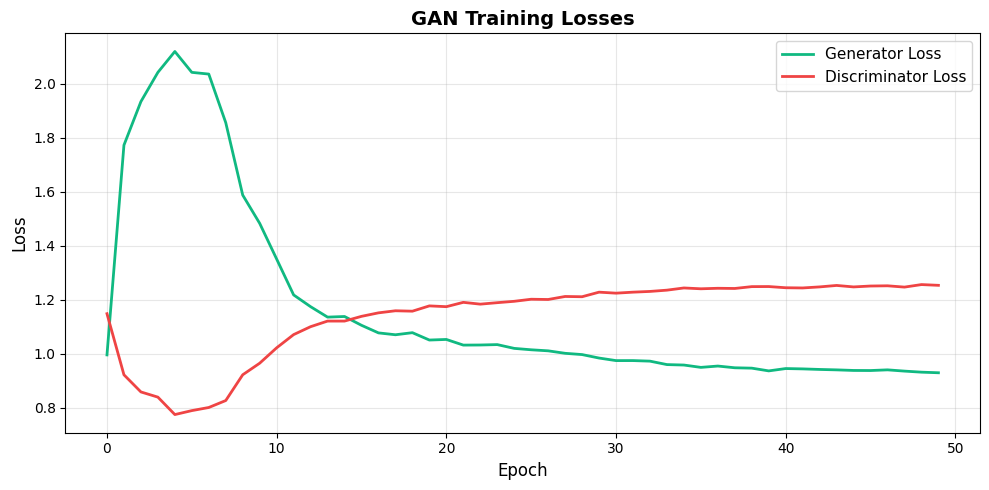


✓ Training loss plot saved as 'training_losses.png'


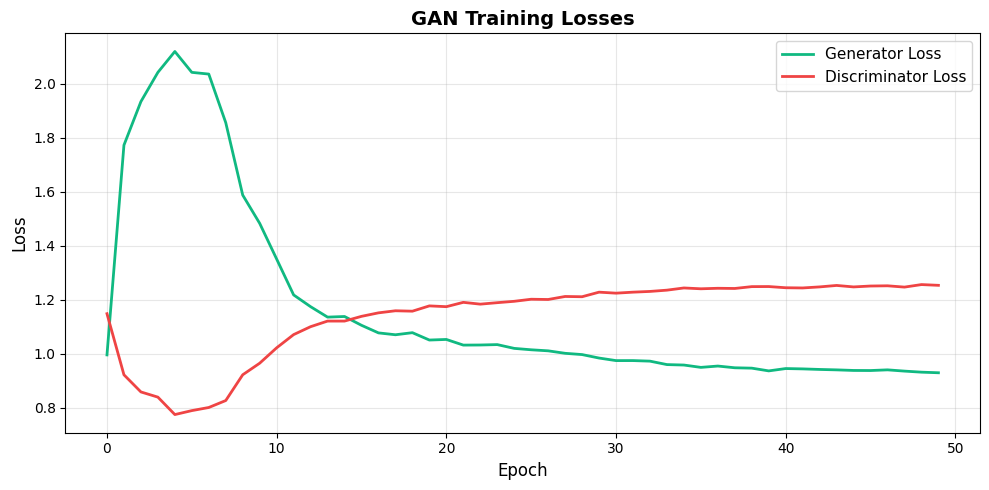


✓ Training loss plot saved as 'training_losses.png'


In [11]:
# 7. VISUALIZE TRAINING PROGRESS

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label='Generator Loss', linewidth=2, color='#10b981')
plt.plot(D_losses, label='Discriminator Loss', linewidth=2, color='#ef4444')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('GAN Training Losses', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('training_losses.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Training loss plot saved as 'training_losses.png'")

GENERATING FINAL IMAGES


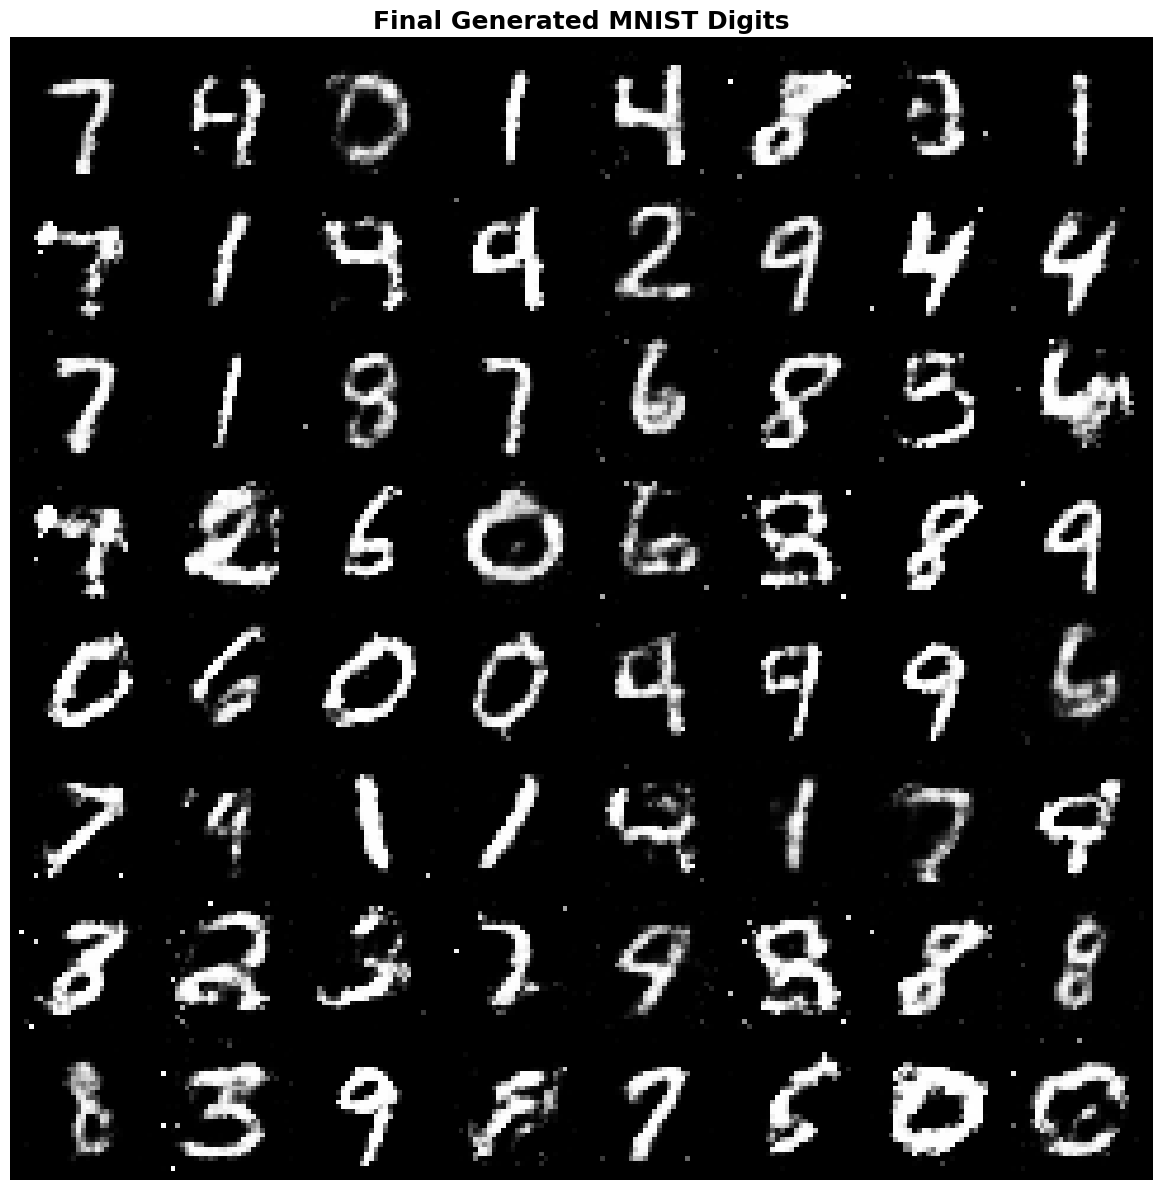

✓ Generated 64 final images
✓ Saved as 'final_generated_digits.png'


In [12]:
# 8. GENERATE FINAL IMAGES

print("GENERATING FINAL IMAGES")

generator.eval()

# Generate a large grid of final images
num_images = 64
noise = generate_noise(num_images)

with torch.no_grad():
    fake_images = generator(noise).view(-1, 1, 28, 28)
    fake_images = (fake_images + 1) / 2  # Denormalize

# Create grid
grid = torchvision.utils.make_grid(fake_images, nrow=8, padding=2)

# Display
plt.figure(figsize=(12, 12))
plt.imshow(grid.cpu().permute(1, 2, 0).squeeze(), cmap='gray')
plt.axis('off')
plt.title('Final Generated MNIST Digits', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.savefig('final_generated_digits.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Generated 64 final images")
print("✓ Saved as 'final_generated_digits.png'")

REAL vs GENERATED COMPARISON


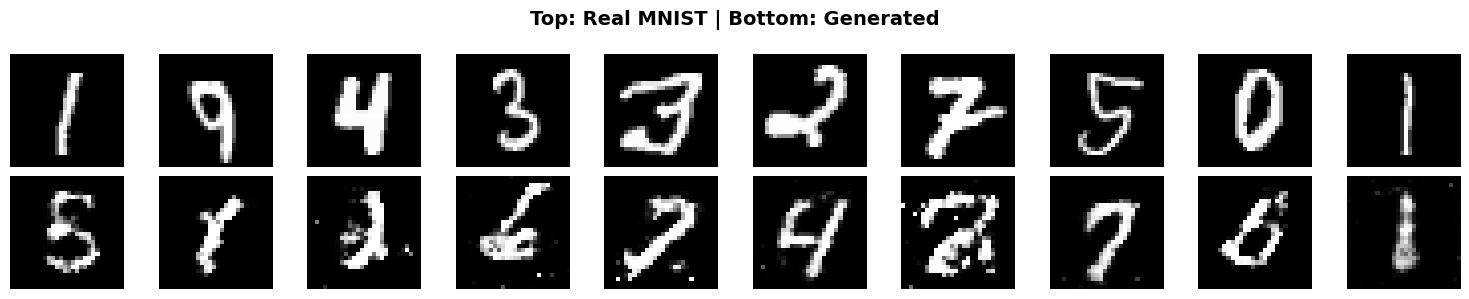

✓ Comparison saved as 'real_vs_generated.png'


In [13]:
# 9. COMPARE REAL VS GENERATED

print("REAL vs GENERATED COMPARISON")

fig, axes = plt.subplots(2, 10, figsize=(15, 3))
fig.suptitle('Top: Real MNIST | Bottom: Generated', fontsize=14, fontweight='bold')

# Get real images
real_images_batch, _ = next(iter(dataloader))
real_images_batch = real_images_batch[:10]

# Top row: Real images
for i in range(10):
    real_img = real_images_batch[i].squeeze()
    real_img = (real_img + 1) / 2  # Denormalize
    axes[0, i].imshow(real_img, cmap='gray')
    axes[0, i].axis('off')

# Bottom row: Generated images
with torch.no_grad():
    noise = generate_noise(10)
    fake_imgs = generator(noise).view(-1, 28, 28)
    fake_imgs = (fake_imgs + 1) / 2  # Denormalize

    for i in range(10):
        axes[1, i].imshow(fake_imgs[i].cpu(), cmap='gray')
        axes[1, i].axis('off')

plt.tight_layout()
plt.savefig('real_vs_generated.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Comparison saved as 'real_vs_generated.png'")


LATENT SPACE INTERPOLATION


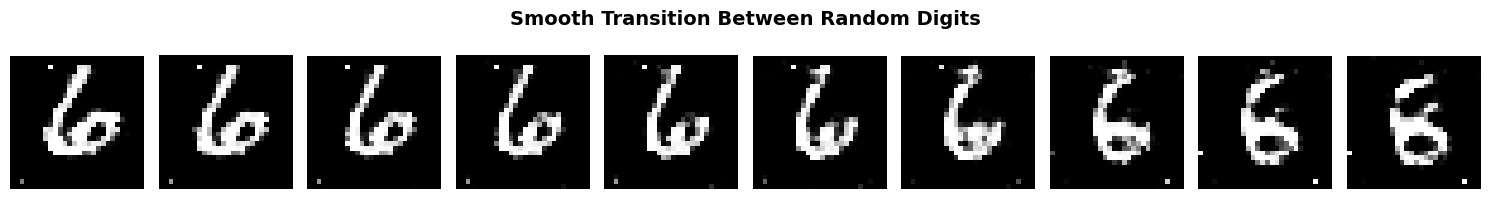

✓ Interpolation saved as 'latent_interpolation.png'


In [14]:
# 10. INTERPOLATION IN LATENT SPACE

print("LATENT SPACE INTERPOLATION")

generator.eval()

# Two random points in latent space
z1 = generate_noise(1)
z2 = generate_noise(1)

# Interpolate between them
steps = 10
fig, axes = plt.subplots(1, steps, figsize=(15, 2))
fig.suptitle('Smooth Transition Between Random Digits', fontsize=14, fontweight='bold')

with torch.no_grad():
    for i, alpha in enumerate(np.linspace(0, 1, steps)):
        # Linear interpolation
        z_interp = (1 - alpha) * z1 + alpha * z2
        fake_img = generator(z_interp).view(28, 28)
        fake_img = (fake_img + 1) / 2

        axes[i].imshow(fake_img.cpu(), cmap='gray')
        axes[i].axis('off')

plt.tight_layout()
plt.savefig('latent_interpolation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Interpolation saved as 'latent_interpolation.png'")

In [16]:
# 11. SAVE MODELS

torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

print("MODELS SAVED")
print("✓ generator.pth")
print("✓ discriminator.pth")

MODELS SAVED
✓ generator.pth
✓ discriminator.pth


In [20]:
# 12. SUMMARY

print("SUMMARY")
print(f"✓ Trained for {NUM_EPOCHS} epochs")
print(f"✓ Final Generator Loss: {G_losses[-1]:.4f}")
print(f"✓ Final Discriminator Loss: {D_losses[-1]:.4f}")
print("\nGenerated Files:")
print(" training_losses.png (loss curves)")
print(" final_generated_digits.png (64 samples)")
print(" real_vs_generated.png (comparison)")
print(" latent_interpolation.png (smooth transitions)")
print(" generator.pth (model weights)")
print(" discriminator.pth (model weights)")

SUMMARY
✓ Trained for 50 epochs
✓ Final Generator Loss: 0.9298
✓ Final Discriminator Loss: 1.2534

Generated Files:
 training_losses.png (loss curves)
 final_generated_digits.png (64 samples)
 real_vs_generated.png (comparison)
 latent_interpolation.png (smooth transitions)
 generator.pth (model weights)
 discriminator.pth (model weights)


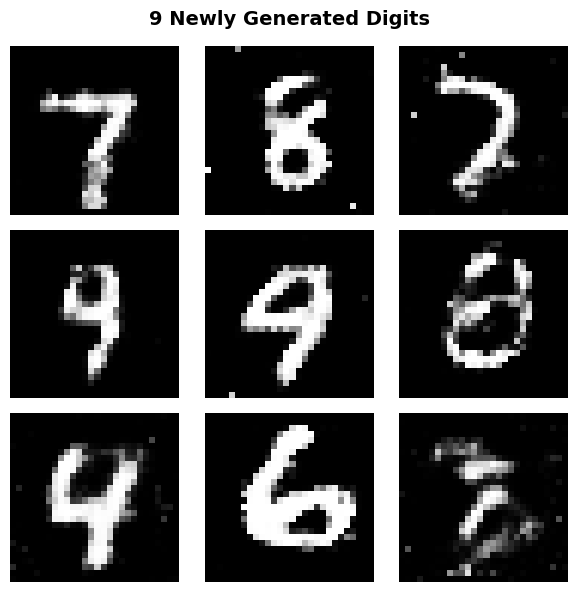

In [27]:
# 13. INTERACTIVE GENERATION FUNCTION

def generate_new_digits(num_digits=9):
    """Generate and display new random digits"""
    generator.eval()

    noise = generate_noise(num_digits)

    with torch.no_grad():
        fake_images = generator(noise).view(-1, 28, 28)
        fake_images = (fake_images + 1) / 2

    # Display in grid
    rows = int(np.sqrt(num_digits))
    cols = int(np.ceil(num_digits / rows))

    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    fig.suptitle(f'{num_digits} Newly Generated Digits', fontsize=14, fontweight='bold')

    for idx in range(num_digits):
        row = idx // cols
        col = idx % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.imshow(fake_images[idx].cpu(), cmap='gray')
        ax.axis('off')

    # Hide extra subplots
    for idx in range(num_digits, rows * cols):
        row = idx // cols
        col = idx % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.axis('off')

    plt.tight_layout()
    plt.show()
generate_new_digits(num_digits=9)